# LABORATORIO 6


Este es un entrenamiento y prueba de aprendizaje por refuerzo del juego de carta Black Jack
donde elaboramos un modelo que logra jugar el juego de una manera efectiva

Grupo 4
Integrantes

1. Aly Delgado Danner Abel
2. Lujan Renteria
3. Itzel Emily Velasquez Guerra
4. Julio Cesar Ortega Albarado
5. Rojas Vasquez Sheila

**Descripción del juego:**
Backjack es un juego popular, en esta versión utiliza un mazo infinito por lo que contar cartas no es una estrategia viable.
El objetivo del juego para ganar es que la suma de las cartas debe ser mayor que la del dealer sin exceder de 21.


*   Acciones: Los players pueden elegir entre dos acciones:
Stand(0): El jugador no toma más cartas
Hit(1): El jugador recibe otra carta, lo cual podría superar los 21 y perder.
*   Espacio de acción: 0-stand y 1-hit
*   Espacio de Observación: suma actual del player, tarjeta visible del dealer, si el jugador  tiene un as utilizable 0 o 1

El juego comienza con el dealer con una carta boca arriba y una boca abajo, el jugador tiene 2 cartas boca arriba.
Los valores de la tarjeta son:

*   Las cartas faciales (Jack, Queen, King) tienen un valor de punto de 10.
*   Los ases pueden contar como 11 (llamados ‘ace’ utilizable) o 1.
*   Las tarjetas numéricas (2-9) tienen un valor igual a su número.

El jugador puede solicitar cartas adicionales  (Hit) hasta detenerse o exceder los 21, cuando el player se detiene el dealer revela su carta boca abajo y solicita cartas hasta que su suma sea 17 o mayor. Si el dealer sobrepasa los 21, el jugador gana.
Si ni el jugador ni el dealer fracasan, el resultado (ganar, perder, empatar) es decidido por cuya suma está más cerca de 21.
El episodio termina si:
El jugador supera 21 (pérdida automática).
El jugador elige "stand" y el crupier completa su turno.
El crupier supera 21 (ganancia automática del jugador).



Recompensas
* ganar juego: +1
* perder juego: -1
* empate: 0
* ganar juego con blackjack natural: +1.5 (si natural es Verdadero) +1 (si natural es Falso)


En este cuadernillo se realiza el entrenamiento y prueba del modelo de aprendizaje por refuerzo
El modelo utilizado es Q-Learning y se realizan pruebas con el agente entrenado.

## Entrenamiento del modelo

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.6 MB/s eta 0:00:00


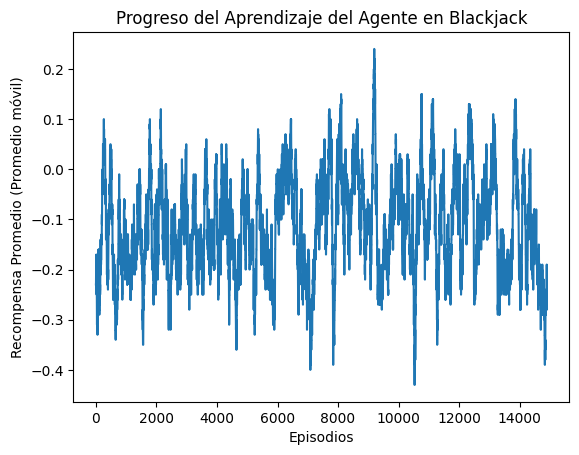

In [40]:
import gymnasium as gym
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Inicializar el entorno
env = gym.make("Blackjack-v1", natural=False)

# Parámetros de Q-learning
#Tasa de aprendizaje: Determina cuanto se ajustan los valores en la Q-table luego de cada iteración mas bajo son estimaciones lentas mas alto (1) no toma en cuenta experiencias pasadas
#Factor de descuento: Pondera las recompensas futuras cercano a 0 prioriza recompensas inmediatas, cercano a 1 recompensas a largo plazo
#Tasa de exploración: Indica la probabilidad de tomar una acción aleatoria para explorar en lugar de una conocida explotar

alpha = 0.01     # Tasa de aprendizaje
gamma = 0.99   # Factor de descuento
epsilon = 0.1  # Tasa de exploración 10% exploración  y 90 % explotación

# Inicializar Q-table con ceros para cada combinación posible de estado y acción
q_table = {}
for player_sum in range(4, 22):  # Suma actual del jugador (4 a 21)
    for dealer_card in range(1, 11):  # Suma actual del jugador (4 a 21)
        for usable_ace in [0, 1]:   # As utilizable (0 o 1)
            q_table[(player_sum, dealer_card, usable_ace)] = [0, 0]  # Palo, Golpear

# Definir la política de acción (ε-greedy)
#La politica de acción de e-greedy es una estrategia para equilibrar entre exploración y explotación
def choose_action(state, training=True):
    if training and np.random.rand() < epsilon:
        return env.action_space.sample() # Explorar: elegir acción aleatoriamente
    else:
        return np.argmax(q_table[state]) # Explotar: elegir la mejor acción según Q-table

# Lista para registrar las recompensas por episodio
rewards_per_episode = []

# Entrenar el agente con Q-learning
for episode in range(15000):
    state, info = env.reset() #Resetear el entorno
    done = False #indica que el episodio no ha terminado
    total_reward = 0

    while not done:
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Actualizar Q-table usando la ecuación de Q-learning
        if not done:
          #devuelve el indice de la mejor acción posible en el estado "next_state"n con el q mas alto
            next_action = np.argmax(q_table[next_state])
            #Ecuación de belman : Actualiza la q-table
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            # Si el episodio terminó, no hay siguiente estado; solo usar la recompensa
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        # Acumular la recompensa
        total_reward += reward
        state = next_state

    # Guardar la recompensa total del episodio
    rewards_per_episode.append(total_reward)
#abre el archivo en modo escritura wb
with open ("q_table_blackjack4.pkl", "wb") as file:
#Guarda el q-table en el archivo
  pickle.dump(q_table, file)


# Suavizar la recompensa usando un promedio móvil para mejorar la visualización
window_size = 100
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')

# Graficar las recompensas suavizadas por episodio
plt.plot(smoothed_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (Promedio móvil)')
plt.title('Progreso del Aprendizaje del Agente en Blackjack')
plt.show()


## Q-table
Valores de acciones para cada estado

In [41]:
# Imprimir la Q-table
for state, actions in q_table.items():
    print(f"Estado {state}: Palo={actions[0]:.2f}, Golpear={actions[1]:.2f}")

Estado (4, 1, 0): Palo=-0.01, Golpear=-0.00
Estado (4, 1, 1): Palo=0.00, Golpear=0.00
Estado (4, 2, 0): Palo=-0.01, Golpear=-0.00
Estado (4, 2, 1): Palo=0.00, Golpear=0.00
Estado (4, 3, 0): Palo=-0.00, Golpear=-0.00
Estado (4, 3, 1): Palo=0.00, Golpear=0.00
Estado (4, 4, 0): Palo=-0.01, Golpear=-0.00
Estado (4, 4, 1): Palo=0.00, Golpear=0.00
Estado (4, 5, 0): Palo=-0.01, Golpear=-0.00
Estado (4, 5, 1): Palo=0.00, Golpear=0.00
Estado (4, 6, 0): Palo=-0.00, Golpear=0.00
Estado (4, 6, 1): Palo=0.00, Golpear=0.00
Estado (4, 7, 0): Palo=-0.02, Golpear=-0.01
Estado (4, 7, 1): Palo=0.00, Golpear=0.00
Estado (4, 8, 0): Palo=-0.01, Golpear=-0.00
Estado (4, 8, 1): Palo=0.00, Golpear=0.00
Estado (4, 9, 0): Palo=-0.00, Golpear=-0.00
Estado (4, 9, 1): Palo=0.00, Golpear=0.00
Estado (4, 10, 0): Palo=-0.03, Golpear=-0.03
Estado (4, 10, 1): Palo=0.00, Golpear=0.00
Estado (5, 1, 0): Palo=-0.04, Golpear=-0.01
Estado (5, 1, 1): Palo=0.00, Golpear=0.00
Estado (5, 2, 0): Palo=-0.01, Golpear=-0.00
Estado (5

## Prueba del modelo con EXPLOTACION

In [42]:
# Prueba del agente después de entrenar usando la Q-table guardada
def test_agent(num_episodes=1000):  # Reducimos el número de episodios para hacer el resultado más legible
    wins, losses, draws = 0, 0, 0

    # Cargar la Q-table guardada
    with open("q_table_blackjack4.pkl", "rb") as file:
        q_table = pickle.load(file)

    # Jugar con el agente entrenado
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False #definir que el juego no ha terminado
        episode_steps = []  # Lista para almacenar el historial de jugadas del episodio
        final_player_sum = None

        print(f"\n--- Episodio {episode + 1} ---")

        while not done: #mientras el episodio no temrine
            # Obtener la acción de la Q-table
            action = np.argmax(q_table[state])  # Seleccionar la mejor acción según la Q-table

            # Registrar el estado actual y la acción
            player_sum, dealer_card, usable_ace = state
            action_name = "Golpear" if action == 1 else "Palo"
            episode_steps.append({
                "Jugador": player_sum,
                "Carta Crupier": dealer_card,
                "As Utilizable": usable_ace,
                "Acción": action_name
            })

            # Si el jugador elige "palo", guardamos la suma final del jugador
            if action == 0:  # Si elige "Palo"
                final_player_sum = player_sum

            # Realizar la acción
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        # Resultado final del episodio
        if reward == 1:
            wins += 1
            outcome = "Ganó"
        elif reward == -1:
            losses += 1
            outcome = "Perdió"
        else:
            draws += 1
            outcome = "Empató"

        # Mostrar el historial del episodio
        print(f"Resultado: {outcome}")
        for step, details in enumerate(episode_steps):
            print(f"Jugada {step + 1}: Jugador={details['Jugador']}, "
                  f"Carta Crupier={details['Carta Crupier']}, "
                  f"As Utilizable={details['As Utilizable']}, "
                  f"Acción={details['Acción']}")

        # Mostrar el puntaje final del jugador
        print(f"Jugador terminó con: {final_player_sum}")

    print(f"\nResultados tras {num_episodes} episodios:")
    print(f"Victorias: {wins}")
    print(f"Derrotas: {losses}")
    print(f"Empates: {draws}")
    print(f"Total ganadas: {wins}")
    print(f"Total perdidas: {losses}")

# Ejecutar el test del agente
test_agent()


Se truncaron las últimas líneas 5000 del resultado de transmisión.

--- Episodio 87 ---
Resultado: Perdió
Jugada 1: Jugador=13, Carta Crupier=1, As Utilizable=0, Acción=Golpear
Jugador terminó con: None

--- Episodio 88 ---
Resultado: Ganó
Jugada 1: Jugador=12, Carta Crupier=10, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=14, Carta Crupier=10, As Utilizable=0, Acción=Palo
Jugador terminó con: 14

--- Episodio 89 ---
Resultado: Ganó
Jugada 1: Jugador=12, Carta Crupier=1, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=14, Carta Crupier=1, As Utilizable=0, Acción=Golpear
Jugada 3: Jugador=20, Carta Crupier=1, As Utilizable=0, Acción=Palo
Jugador terminó con: 20

--- Episodio 90 ---
Resultado: Ganó
Jugada 1: Jugador=21, Carta Crupier=10, As Utilizable=1, Acción=Palo
Jugador terminó con: 21

--- Episodio 91 ---
Resultado: Ganó
Jugada 1: Jugador=20, Carta Crupier=5, As Utilizable=0, Acción=Palo
Jugador terminó con: 20

--- Episodio 92 ---
Resultado: Perdió
Jugada 1: Jugador=19, Cart